In [ ]:
# left: jacobin
# central: reuters
# right: newsmax

In [2]:
import random
import requests

def fetch_jacobin_article_fragments(article_url):
    print(f"fetching article: {article_url}")

    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return None

        soup = BeautifulSoup(response.content, "html.parser")

        body = soup.select("div#post-content")
        content = " ".join(p.get_text(strip=True) for p in body)
        print(f"article content: {content}")

        # fragments containing "Trump" or "Biden"
        fragments = []
        sentences = re.split(r'(?<=[.!?])\s+', content)
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Biden)\b', sentence, re.IGNORECASE):
                # choose 1,2,3 consecutive sentences
                num_sentences = random.choice([1, 2, 3])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        print(f"relevant fragments: {fragments}")
        return fragments
    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return None

def fetch_jacobin_data(url, max_texts=100):
    fragments = []
    base_url = "https://jacobin.com"
    page = 1

    while len(fragments) < max_texts:
        paginated_url = f"{url}&page={page}"
        response = requests.get(paginated_url)
        if response.status_code != 200:
            print(f"Failed to fetch page {page}: {response.status_code}")
            break

        soup = BeautifulSoup(response.content, "html.parser")
        divs = soup.find_all("div", class_="ar-mn__main")
        article_links = []
        for div in divs:
            a_tags = div.find_all("a")
            for a_tag in a_tags:
                href = a_tag.get("href")
                if href:
                    article_links.append(href)
                    break  # there are 2 links to each article

        if not article_links:
            print("No more articles found.")
            break

        for link in article_links:
            if len(fragments) >= max_texts:
                break

            article_url = base_url + link
            article_fragments = fetch_jacobin_article_fragments(article_url)
            if article_fragments:
                fragments.extend([(frag, "left") for frag in article_fragments])

        page += 1

    return fragments[:max_texts]

def get_2020_data_jacobin():
  # Trump vs Biden
  data = [] # (text, leaning), leaning="left"

  urls = ["https://jacobin.com/search?query=+donald+trump+2020+elections", "https://jacobin.com/search?query=donald+trump+presidential+candidate+2020",
          "https://jacobin.com/search?query=joe+biden+2020+elections", "https://jacobin.com/search?query=joe+biden+2020+presidential+rally"]
  for url in urls:
    data += fetch_jacobin_data(url, max_texts=100)
  return data

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 22.7 MB/s eta 0:00:00


In [3]:
import requests
from bs4 import BeautifulSoup
import re
import random
import time

def fetch_google_search_apnews_results(query_url, max_results=10, max_pages=4):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    article_urls = []
    page = 0
    while len(article_urls) < max_results and page < max_pages:
        # Add pagination to the query
        paginated_url = f"{query_url}&start={page * 10}"

        try:
            response = requests.get(paginated_url, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch search results: {response.status_code}")
                return []

            soup = BeautifulSoup(response.text, "html.parser")
            links = soup.find_all("a")
            for link in links:
                href = link.get("href")
                if href and "apnews.com" in href:  # Filter AP News links
                    matched = re.search(r"https://apnews.com/[^\s&]*", href)
                    if matched:
                        article_url = matched.group(0)
                        if article_url not in article_urls:
                            article_urls.append(article_url)

            page += 1
            time.sleep(random.uniform(1, 2))  # To avoid getting blocked

        except Exception as e:
            print(f"Error fetching Google search results: {e}")
            break

    return article_urls[:max_results]  # Return the desired number of URLs

def fetch_apnews_article_fragments(article_url):
    print(f"Fetching AP News article: {article_url}")
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    try:
        response = requests.get(article_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return []

        soup = BeautifulSoup(response.content, "html.parser")
        body = soup.find("div", {"class": "Page-storyBody"})

        if not body:
            print("Article body not found.")
            return []

        content = " ".join(p.get_text(strip=True) for p in body.find_all("p"))
        sentences = re.split(r'(?<=[.!?])\s+', content)

        fragments = []
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Biden)\b', sentence, re.IGNORECASE):
                num_sentences = random.choice([2, 3, 4])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return []

def fetch_apnews_data(query_url, max_texts=100):
    article_urls = fetch_google_search_apnews_results(query_url, max_results=max_texts)
    all_fragments = []
    for url in article_urls:
        fragments = fetch_apnews_article_fragments(url)
        all_fragments.extend((fragment, "center") for fragment in fragments)
        if len(all_fragments) >= max_texts:
            break
        time.sleep(random.uniform(1, 2))
    return all_fragments

def get_2020_data_apnews():
    data = []  # (text, leaning), leaning="center"
    urls = [
        "https://www.google.com/search?q=site%3Aapnews.com+donald+trump+2020+elections+after%3A2018-01-01+before%3A2021-06-01",
        "https://www.google.com/search?q=site%3Aapnews.com+joe+biden+2020+elections+after%3A2018-01-01+before%3A2021-06-01"
    ]
    for url in urls:
        data += fetch_apnews_data(url, max_texts=400)
    return data


In [22]:
import requests
from bs4 import BeautifulSoup
import re
import random
import time

def fetch_google_search_newsmax_results(query_url, max_results=10):
    headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    article_urls = []
    page = 0
    while len(article_urls) < max_results:
        print(f"will get some google articles... size of article_urls: {len(article_urls)}")
        paginated_url = f"{query_url}&start={page * 10 + 3}"

        try:
            response = requests.get(paginated_url, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch Google results: {response.status_code}")
                return []

            soup = BeautifulSoup(response.text, "html.parser")
            links = soup.find_all("a")
            for link in links:
                href = link.get("href")
                if href and "newsmax.com" in href:
                    matched = re.search(r"https://www\.newsmax\.com/[^\s&]*", href)
                    if matched:
                        article_url = matched.group(0)
                        if article_url not in article_urls:
                            article_urls.append(article_url)

            page += 1
            time.sleep(random.uniform(1, 2))

        except Exception as e:
            print(f"Error fetching Google search results: {e}")
            break

    return article_urls[:max_results]

def fetch_newsmax_article_fragments(article_url):
    print(f"Fetching Newsmax article: {article_url}")

    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return []
        print(f"response content: {response.content}")

        soup = BeautifulSoup(response.content, "html.parser")
        body = soup.find("div", {"id": "mainArticleDiv"})

        content = " ".join(p.get_text(strip=True) for p in body.find_all("p"))
        sentences = re.split(r'(?<=[.!?])\s+', content)

        fragments = []
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Biden)\b', sentence, re.IGNORECASE): # sentences mentioning either candidate
                num_sentences = random.choice([2, 3, 4])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return []

def fetch_newsmax_data(query_url, max_texts=100):
    article_urls = fetch_google_search_newsmax_results(query_url, max_results=max_texts)
    all_fragments = []
    for url in article_urls:
        fragments = fetch_newsmax_article_fragments(url)
        all_fragments.extend((fragment, "right") for fragment in fragments)
        if len(all_fragments) >= max_texts:
            break
        time.sleep(random.uniform(1, 2))
    return all_fragments

def get_2020_data_newsmax():
    data = []  # (text, leaning), leaning="right"


    # TODO unless we get 429 (too many requests), use the fetch_newsmax_data function
    # urls = [
    #     "https://www.google.com/search?q=site%3Anewsmax.com+donald+trump+2020+elections+after%3A2018-01-01+before%3A2021-06-01",
    #     "https://www.google.com/search?q=site%3Anewsmax.com+joe+biden+2020+elections+after%3A2018-01-01+before%3A2021-06-01"
    # ]
    # for url in urls:
    #     data += fetch_newsmax_data(url, max_texts=400)
    handpicked_article_urls = [
        "https://www.newsmax.com/newsfront/trump-russia-biden-denigrate/2020/08/07/id/981199/",
        "https://www.newsmax.com/politics/jim-mclaughlin-pollster-philadelphia-pennsylvania/2020/11/04/id/995328/",
        "https://www.newsmax.com/politics/rasmussen-biden-election/2020/10/06/id/990530/",
        "https://www.newsmax.com/politics/trump-election-flynn-martiallaw/2020/12/17/id/1002139/",
        "https://www.newsmax.com/michaeldorstewitz/vote-fraud-baseless-merit-scotus/2021/01/02/id/1003982/",
        "https://www.newsmax.com/us/election-challenge-electoral-college-republicans-house/2020/12/22/id/1002765/",
        "https://www.newsmax.com/politics/rasmussen-biden-election/2020/10/06/id/990530/",
        "https://www.newsmax.com/politics/electoral-college-electors-trump-biden/2020/11/19/id/997869/",
        "https://www.newsmax.com/us/election-challenge-electoral-college-republicans-house/2020/12/22/id/1002765/",
        "https://www.newsmax.com/newsfront/abrams-pardon-barr/2020/05/15/id/967530/",
        "https://www.newsmax.com/newsfront/trump-russia-biden-denigrate/2020/08/07/id/981199",
        "https://www.newsmax.com/amp/headline/election-2020-america-disrupted-seniors-abridged/2020/10/10/id/991330/",
        "https://www.newsmax.com/newsmax-tv/jenna-ellis-newsmax-tv-election-challenge/2020/12/16/id/1001862/",
        "https://www.newsmax.com/politics/jim-mclaughlin-pollster-philadelphia-pennsylvania/2020/11/04/id/995328/",
        "https://www.newsmax.com/politics/biden-villages-golfcart-parade/2020/08/21/id/983385/",
        "https://www.newsmax.com/politics/pennsylvania-judge-order-ruling/2020/11/28/id/999095/"
    ]
    for url in handpicked_article_urls:
        fragments = fetch_newsmax_article_fragments(url)
        data.extend((fragment, "right") for fragment in fragments)

    return data


In [5]:
def get_data_for_year(year):
  if year == 2020:
    data = []
    # data += get_2020_data_jacobin()
    # data += get_2020_data_apnews()
    data += get_2020_data_newsmax()

    return data

In [ ]:
data_2020 = get_data_for_year(2020)

print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")

Fetching AP News article: https://apnews.com/article/donald-trump-michael-pence-electoral-college-elections-health-2d9bd47a8bd3561682ac46c6b3873a10
Fetching AP News article: https://apnews.com/article/virus-outbreak-joe-biden-election-2020-donald-trump-elections-3e8170c3348ce3719d4bc7182146b582
Fetching AP News article: https://apnews.com/article/election-2020-joe-biden-donald-trump-elections-coronavirus-pandemic-f76f7c7c7182be4033151457ca81a9f7
Fetching AP News article: https://apnews.com/article/election-2020-joe-biden-donald-trump-barack-obama-elections-89ff0c83049f6eac32f09271756775de
Fetching AP News article: https://apnews.com/article/election-2020-ap-fact-check-joe-biden-donald-trump-technology-49a24edd6d10888dbad61689c24b05a5
Fetching AP News article: https://apnews.com/article/election-2020-joe-biden-donald-trump-senate-elections-gary-peters-19decf3108373883409fae7e6e810ac6
Fetching AP News article: https://apnews.com/article/election-2020-donald-trump-virus-outbreak-general-e

In [ ]:
data_2020_jacobin = get_data_for_year(2020)

print(f"data_2020_2[...]:{data_2020_jacobin[random.randint(0, 20)]}")

fetching article: https://jacobin.com/2017/09/democratic-party-2016-election-working-class
article content: Even before Donald Trump’s shocking victory last November, the press had alreadywrittenthe story of his rise. Despitestudiesshowing that, likeall Republican candidates, well-off whites formed the core of Trump’s support, pundits zeroed in on his white working-class backers, which most commentators defined solely in terms of education (whites without a college degree).This dividing line ignored other crucial variables — such as income, self-identification, and occupation — but it fit with the popular belief that, from the office cubicle to the voting booth, the postindustrial “New Economy” separated the intelligent from the ignorant in a virtuousmeritocracy.By the time Hillary Clinton conceded to Trump, non-college whites had become conflated with both the working class and racism itself. The Trump campaign, as one punditargued, “laid bare the racial animus within the white workin

In [ ]:
print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")
print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")
print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")


data_2020[...]:('“This is not a thing. “Instead, it was up to Congress to count the valid electoral college votes submitted by the states, which it did.” TRUMP: The election was “corrupt” and “was indeed The Big Lie.” — statement Thursday. THE FACTS: To be clear, no widespread corruption was found and no election was stolen from Trump.', 'center')
data_2020[...]:('TRUMP: “Had Mike Pence referred the information on six states (only need two) back to State Legislatures ... we would have had a far different Presidential result.” — statement Wednesday urging Republicans to push outRep.', 'center')
data_2020[...]:('Biden earned 306 electoral votes to Trump’s 232, the same margin that Trump had when he beat Hillary Clinton in 2016, which he repeatedly described as a “landslide.” (Trump ended up with 304 electoral votes because two electors defected.) Biden achieved victory by prevailing in key states such as Pennsylvania, Michigan, Wisconsin, Arizona and Georgia. Trump’s former attorney gene

In [23]:
data_2020_newsmax = get_data_for_year(2020)

print(f"data_2020_2[...]:{data_2020_newsmax[random.randint(0, 20)]}")

Fetching Newsmax article: https://www.newsmax.com/newsfront/trump-russia-biden-denigrate/2020/08/07/id/981199/
response content: b'<!DOCTYPE html>\r\n<html   lang="en">\r\n<head id="head">\r\n<title>\r\n\tTrump Derides Intelligence Statement on Russian Election Interference | Newsmax.com\r\n</title><meta name="epoch" content="1596840174" />\r\n<meta name="pubdate" property="pubdate" content="2020-08-07T22:42:54-04:00" />\r\n<meta property="article:section" content="newsfront" />\r\n<meta property="article:published_time" content="2020-08-07T22:42:54-04:00" />\r\n<meta name="og:description" property="og:description" content="President Donald Trump derided the conclusion by U.S. intelligence officials that Russia is trying to &quot;denigrate&quot; presumptive Democratic presidential nominee Joe Biden in favor of Trump, saying no president has been more aggressive with Russia than him." />\r\n<meta name="og:page_id" property="og:page_id" content="85452072376" />\r\n<meta name="fb:app_id" 

In [8]:
print("servus")

servus


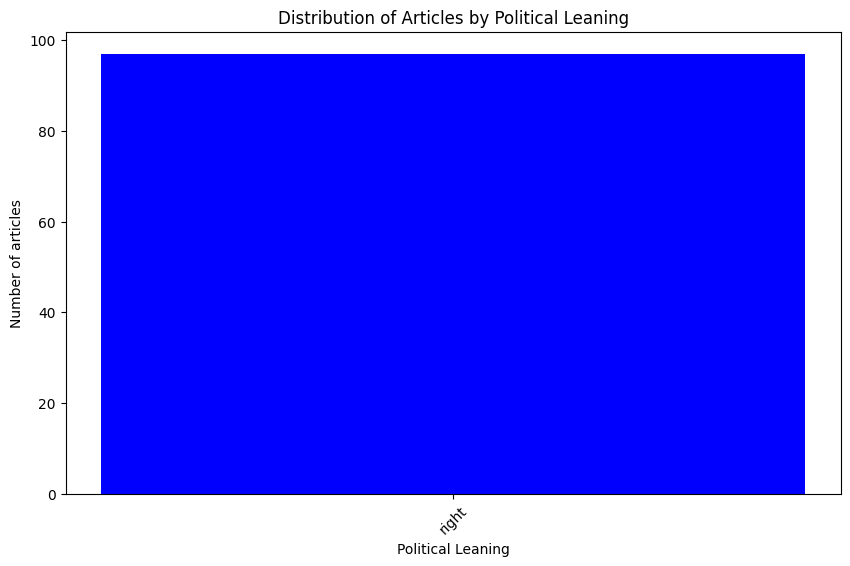

Total articles: 97
Distribution by political leaning:
right: 97


In [24]:
# data analysis

from collections import Counter
import matplotlib.pyplot as plt

def display_statistics(data):
    leanings = [fragment[1] for fragment in data] # data: [(text, leaning), ...]
    counts = Counter(leanings)

    labels = counts.keys()
    values = counts.values()

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='blue')
    plt.xlabel('Political Leaning')
    plt.ylabel('Number of articles')
    plt.title('Distribution of Articles by Political Leaning')
    plt.xticks(rotation=45)
    plt.show()

    print("Total articles:", len(data))
    print("Distribution by political leaning:")
    for leaning, count in counts.items():
        print(f"{leaning}: {count}")

display_statistics(data_2020_newsmax)


In [25]:
import csv

def save_data(data, filename="2020_election_data.csv"):
    data_with_year = [(text, leaning, 2020) for text, leaning in data]

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Text", "Leaning", "Year"])
        writer.writerows(data_with_year)

    print(f"Saved to {filename}")

save_data(data_2020_newsmax)

Saved to 2020_election_data.csv
